In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm, ensemble
from sklearn.ensemble import AdaBoostRegressor
import time
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import ShuffleSplit
import random
pd.options.mode.chained_assignment = None

weather = pd.read_csv('data/weather.csv')
pallet_history = pd.read_csv('data/Pallet_history_Gold_Spike.csv')
inbound = pd.read_csv('data/inbound_loads.csv')
outbound = pd.read_csv('data/outbound_laods.csv')
demand = pd.read_csv('data/demand_kWtrain_val.csv')

# Creating the train, val, test sets

In [2]:
#################
# Preprocess inbound csv:
#################
print('\n #####\nInbound: \n ##### \n')
inbound_post = inbound[inbound.carrier_code != 'CANCEL']
inbound_post = inbound[inbound.carrier_code != '']

inbound_post['truck_signin_datetime'] = pd.to_datetime(inbound_post['truck_signin_datetime'])

# Compute delta times
inbound_load_time = pd.to_datetime(inbound_post['load_finish_datetime']) - pd.to_datetime(inbound_post['load_start_datetime'])
inbound_truck_time = pd.to_datetime(inbound_post['truck_signin_datetime']) - pd.to_datetime(inbound_post['signout_datetime'])

# Drop unnecessary columns
inbound_post = inbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
inbound_post['load_time'] = inbound_load_time
inbound_post['truck_time'] = inbound_truck_time

print(inbound_post.columns)

inbound_post['load_time'] = inbound_post['load_time'].dt.seconds
inbound_post['truck_time'] = inbound_post['truck_time'].dt.seconds

print('With NaN:', inbound_post.shape)

# Drop rows with >0 NaN values
inbound_post_nan = inbound_post.dropna().reset_index(drop=True)

print('Without NaN:', inbound_post_nan.shape)

#################
# Preprocess outbound csv:
#################
print('\n #####\nOutbound: \n ##### \n')
outbound_post = outbound[outbound.carrier_code != 'CANCEL']
outbound_post = outbound[outbound.carrier_code != 'VOID']
outbound_post = outbound[outbound.carrier_code != '']

outbound_post['truck_signin_datetime'] = pd.to_datetime(outbound_post['truck_signin_datetime'])

# Compute delta times
outbound_load_time = pd.to_datetime(outbound_post['load_finish_datetime']) - pd.to_datetime(outbound_post['load_start_datetime'])
outbound_truck_time = pd.to_datetime(outbound_post['truck_signin_datetime']) - pd.to_datetime(outbound_post['signout_datetime'])

# Drop unnecessary columns
outbound_post = outbound_post.drop(['Unnamed: 0', 'warehouse_order_number', 'customer_code', 'load_reference_number', 'carrier_code', 'weight_uom', 'load_finish_datetime', 'load_start_datetime', 'dock_door_number', 'trailer_number', 'signout_datetime'], axis=1)

# Add time deltas
outbound_post['load_time'] = outbound_load_time
outbound_post['truck_time'] = outbound_truck_time

print(outbound_post.columns)

outbound_post['load_time'] = outbound_post['load_time'].dt.seconds
outbound_post['truck_time'] = outbound_post['truck_time'].dt.seconds

print('With NaN:', outbound_post.shape)

# Drop rows with >0 NaN values
outbound_post_nan = outbound_post.dropna().reset_index(drop=True)

print('Without NaN:', outbound_post_nan.shape)

#################
# Preprocess demand csv:
#################
print('\n #####\nDemand:  \n ##### \n')

demand['datetime_local'] = pd.to_datetime(demand['datetime_local'])

# How to split time series:
# https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
def split_train_val_test(data, end_known_idx, split=0.7):
    '''Splits dataset into train val and test
    
    Test set is inferred from end_known_idx (int)
    Train size is dictated by split (float)
    Train and val are randomly split in correct proportions
    
    Input: 
        data: pd dataframe
        end_known_idx: index of start of test set (int)
        split: float indicating size of train set (known -> train, val)
    Output:
        (train_set, val_set, test_set) tuple
    '''
    known = data.loc[0:end_known_idx]
    test_set = data.iloc[end_known_idx:-2]
    # Randomly split train and val out of known with prob. split
    train_idx = random.sample(set(np.arange(end_known_idx)), int(split * end_known_idx))
    train_set = data.iloc[train_idx]
    val_idx = set(np.arange(end_known_idx)) - set(train_idx)
    val_set = data.iloc[list(val_idx)]
    return train_set, val_set, test_set

end_known_idx = demand[demand.demand_kW > 1].index[-1]
train_val_split = 0.7 # 70% train, 30% val
# end_train_idx = int((train_val_split) * end_known_idx)
# demand_train = demand.loc[0:end_train_idx-1]
# demand_val = demand.loc[end_train_idx:end_known_idx]
# demand_test = demand.iloc[end_known_idx+1:-2]
demand_train, demand_val, demand_test = split_train_val_test(demand, end_known_idx, split=train_val_split)

print('Full dataset:', demand.shape)
print('Answers known until index: ', end_known_idx)
print(f'Training set, {int(train_val_split*100)}%:', demand_train.shape)
print(f'Validation set, {int(100-train_val_split*100)}%:', demand_val.shape)
print('Test set', demand_test.shape)

#################
# Preprocess weather csv:
#################
print('\n #####\nWeather:  \n ##### \n')

weather_post = weather.copy()
UTC6 = pd.to_datetime(weather_post['datetime_UTC']) - pd.Timedelta(hours=6)
weather_post['datetime_america'] = UTC6
weather_post = weather_post.drop('datetime_UTC', axis=1)
weather_post = weather_post.drop(['datetime', 'hour', 'Unnamed: 0'], axis=1)

print(weather_post.head())
print(weather_post.columns)
print(weather_post.shape)



 #####
Inbound: 
 ##### 

Index(['front_temperature', 'middle_temperature', 'back_temperature',
       'net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (56146, 9)
Without NaN: (8761, 9)

 #####
Outbound: 
 ##### 

Index(['net_weight', 'case_quantity', 'pallet_count', 'truck_signin_datetime',
       'load_time', 'truck_time'],
      dtype='object')
With NaN: (112363, 6)
Without NaN: (96704, 6)

 #####
Demand:  
 ##### 



C:\Users\karan\AppData\Local\Temp\ipykernel_25044\1733520328.py:92: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_idx = random.sample(set(np.arange(end_known_idx)), int(split * end_known_idx))


Full dataset: (365349, 3)
Answers known until index:  273987
Training set, 70%: (191790, 3)
Validation set, 30%: (82197, 3)
Test set (91360, 3)

 #####
Weather:  
 ##### 

   Relative Humidity  Temperature    datetime_america
0              50.37         53.6 2018-12-31 18:00:00
1              50.37         53.6 2018-12-31 18:05:00
2              50.37         53.6 2018-12-31 18:10:00
3              50.37         53.6 2018-12-31 18:15:00
4              50.37         53.6 2018-12-31 18:20:00
Index(['Relative Humidity', 'Temperature', 'datetime_america'], dtype='object')
(328242, 3)


## Weather to demand

In [3]:
# Combine weather and demand data to train, val, and test sets

weather_post.sort_values("datetime_america", inplace=True)
demand_train.sort_values("datetime_local", inplace=True)
demand_val.sort_values("datetime_local", inplace=True)
demand_test.sort_values("datetime_local", inplace=True)
print("weather", weather_post.shape, '\n')
print("demand_train", demand_train.shape)
print("demand_val", demand_val.shape)
print("demand_test", demand_test.shape, '\n')
demand_weather_train = pd.merge_asof(demand_train, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')
demand_weather_val = pd.merge_asof(demand_val, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')
demand_weather_test = pd.merge_asof(demand_test, weather_post, left_on='datetime_local', right_on='datetime_america', direction='nearest')

# demand_weather_train.set_index('datetime_local', inplace=True)
demand_weather_train = demand_weather_train.drop(['Unnamed: 0','datetime_america'], axis=1)
# demand_weather_val.set_index('datetime_local', inplace=True)
demand_weather_val = demand_weather_val.drop(['Unnamed: 0','datetime_america'], axis=1)
# demand_weather_test.set_index('datetime_local', inplace=True)
demand_weather_test = demand_weather_test.drop(['Unnamed: 0','datetime_america'], axis=1)

print("train merged", demand_weather_train.shape)
print("val merged", demand_weather_val.shape)
print("test merged", demand_weather_test.shape)

demand_weather_train.head()

weather (328242, 3) 

demand_train (191790, 3)
demand_val (82197, 3)
demand_test (91360, 3) 

train merged (191790, 4)
val merged (82197, 4)
test merged (91360, 4)


,datetime_local,demand_kW,Relative Humidity,Temperature
0,2018-12-31 21:15:00,2064.101392,61.27,46.4
1,2018-12-31 21:30:00,1874.002081,61.27,46.4
2,2018-12-31 22:15:00,1986.981872,65.60,44.6
3,2018-12-31 22:30:00,1921.142106,65.60,44.6
4,2018-12-31 23:00:00,2039.546964,65.60,44.6


## Add inbound, but only load time and truck time

In [4]:
# Merging inbound with the above demand/weather dataset. Maximum 15 minutes difference in order to merge.
# Results in NaN and NaT where > 15 mins difference.
inbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
print("train pre", demand_weather_train.shape)
print("val pre", demand_weather_val.shape)
print("test pre", demand_weather_test.shape, '\n')

demand_inbound_merge_train = pd.merge_asof(demand_weather_train, inbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_val = pd.merge_asof(demand_weather_val, inbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_test = pd.merge_asof(demand_weather_test, inbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     tolerance=datetime.timedelta(minutes = 15))

# Add only load time and truck time
demand_inbound_merge_train1 = demand_inbound_merge_train.drop(
    ['truck_signin_datetime', 'front_temperature', 'middle_temperature', 'back_temperature', 'net_weight', 'case_quantity', 'pallet_count'],
      axis=1)
demand_inbound_merge_val1 = demand_inbound_merge_val.drop(
    ['truck_signin_datetime', 'front_temperature', 'middle_temperature', 'back_temperature', 'net_weight', 'case_quantity', 'pallet_count'],
      axis=1)
demand_inbound_merge_test1 = demand_inbound_merge_test.drop(
    ['truck_signin_datetime', 'front_temperature', 'middle_temperature', 'back_temperature', 'net_weight', 'case_quantity', 'pallet_count'],
      axis=1)
# If they are NaN, replace them with 0.0, since 0 seconds has passed.
demand_inbound_merge_train2 = demand_inbound_merge_train1.fillna(value=0, axis=1)
demand_inbound_merge_val2 = demand_inbound_merge_val1.fillna(value=0, axis=1)
demand_inbound_merge_test2 = demand_inbound_merge_test1.fillna(value=0, axis=1)

print("train post", demand_inbound_merge_train2.shape)
print("val post", demand_inbound_merge_val2.shape)
print("test post", demand_inbound_merge_test2.shape)

demand_inbound_merge_train2.head()

train pre (191790, 4)
val pre (82197, 4)
test pre (91360, 4) 

train post (191790, 6)
val post (82197, 6)
test post (91360, 6)


,datetime_local,demand_kW,Relative Humidity,Temperature,load_time,truck_time
0,2018-12-31 21:15:00,2064.101392,61.27,46.4,0,0
1,2018-12-31 21:30:00,1874.002081,61.27,46.4,0,0
2,2018-12-31 22:15:00,1986.981872,65.6,44.6,0,0
3,2018-12-31 22:30:00,1921.142106,65.6,44.6,0,0
4,2018-12-31 23:00:00,2039.546964,65.6,44.6,0,0


## Now also adding outbound, again only load time and truck time. Now adding the times in the columns.

In [5]:
# Merging inbound with the above demand/weather dataset. Maximum 15 minutes difference in order to merge.
# Results in NaN and NaT where > 15 mins difference.
outbound_post_nan.sort_values("truck_signin_datetime", inplace=True)
print("train pre", demand_inbound_merge_train2.shape)
print("val pre", demand_inbound_merge_val2.shape)
print("test pre", demand_inbound_merge_test2.shape, '\n')

demand_inbound_merge_train3 = pd.merge_asof(demand_inbound_merge_train2, outbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     suffixes=('_in', '_out'),
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_val3 = pd.merge_asof(demand_inbound_merge_val2, outbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     suffixes=('_in', '_out'),
                                     tolerance=datetime.timedelta(minutes = 15))
demand_inbound_merge_test3 = pd.merge_asof(demand_inbound_merge_test2, outbound_post_nan, 
                                     left_on='datetime_local', 
                                     right_on='truck_signin_datetime', 
                                     direction='nearest', 
                                     suffixes=('_in', '_out'),
                                     tolerance=datetime.timedelta(minutes = 15))

# Add only load time and truck time
demand_inbound_merge_train4 = demand_inbound_merge_train3.drop(
    ['truck_signin_datetime', 'net_weight', 'case_quantity', 'pallet_count'],
      axis=1)
demand_inbound_merge_val4 = demand_inbound_merge_val3.drop(
    ['truck_signin_datetime', 'net_weight', 'case_quantity', 'pallet_count'],
      axis=1)
demand_inbound_merge_test4 = demand_inbound_merge_test3.drop(
    ['truck_signin_datetime', 'net_weight', 'case_quantity', 'pallet_count'],
      axis=1)

# If they are NaN, replace them with 0.0, since 0 seconds has passed.
demand_inbound_merge_train5 = demand_inbound_merge_train4.fillna(value=0, axis=1)
demand_inbound_merge_val5 = demand_inbound_merge_val4.fillna(value=0, axis=1)
demand_inbound_merge_test5 = demand_inbound_merge_test4.fillna(value=0, axis=1)

# Sum load time and truck time
demand_inbound_merge_train5['load_time'] = demand_inbound_merge_train5['load_time_in'] + demand_inbound_merge_train5['load_time_out']
demand_inbound_merge_val5['load_time'] = demand_inbound_merge_val5['load_time_in'] + demand_inbound_merge_val5['load_time_out']
demand_inbound_merge_test5['load_time'] = demand_inbound_merge_test5['load_time_in'] + demand_inbound_merge_test5['load_time_out']

demand_inbound_merge_train5['truck_time'] = demand_inbound_merge_train5['truck_time_in'] + demand_inbound_merge_train5['truck_time_out']
demand_inbound_merge_val5['truck_time'] = demand_inbound_merge_val5['truck_time_in'] + demand_inbound_merge_val5['truck_time_out']
demand_inbound_merge_test5['truck_time'] = demand_inbound_merge_test5['truck_time_in'] + demand_inbound_merge_test5['truck_time_out']

demand_inbound_merge_train6 = demand_inbound_merge_train5.drop(
    ['load_time_in', 'load_time_out', 'truck_time_in', 'truck_time_out'],
      axis=1)
demand_inbound_merge_val6 = demand_inbound_merge_val5.drop(
    ['load_time_in', 'load_time_out', 'truck_time_in', 'truck_time_out'],
      axis=1)
demand_inbound_merge_test6 = demand_inbound_merge_test5.drop(
    ['load_time_in', 'load_time_out', 'truck_time_in', 'truck_time_out'],
      axis=1)

# demand_inbound_merge_train6.set_index('datetime_local', inplace=True)
# demand_inbound_merge_val6.set_index('datetime_local', inplace=True)
# demand_inbound_merge_test6.set_index('datetime_local', inplace=True)

print("train post", demand_inbound_merge_train6.shape)
print("val post", demand_inbound_merge_val6.shape)
print("test post", demand_inbound_merge_test6.shape)

demand_inbound_merge_train6.head()

train pre (191790, 6)
val pre (82197, 6)
test pre (91360, 6) 

train post (191790, 6)
val post (82197, 6)
test post (91360, 6)


,datetime_local,demand_kW,Relative Humidity,Temperature,load_time,truck_time
0,2018-12-31 21:15:00,2064.101392,61.27,46.4,0,0
1,2018-12-31 21:30:00,1874.002081,61.27,46.4,0,0
2,2018-12-31 22:15:00,1986.981872,65.6,44.6,0,0
3,2018-12-31 22:30:00,1921.142106,65.6,44.6,0,0
4,2018-12-31 23:00:00,2039.546964,65.6,44.6,0,0


## Changing datetime to integers

In [6]:
demand_inbound_merge_train6['datetime_local'] = demand_inbound_merge_train6['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
demand_inbound_merge_val6['datetime_local'] = demand_inbound_merge_val6['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))
demand_inbound_merge_test6['datetime_local'] = demand_inbound_merge_test6['datetime_local'].apply(lambda x: time.mktime(x.timetuple()))

train = demand_inbound_merge_train6
val = demand_inbound_merge_val6
test = demand_inbound_merge_test6

print('train:',train.shape)
print('val:',val.shape)
print('test:',test.shape)

train.head()

train: (191790, 6)
val: (82197, 6)
test: (91360, 6)


,datetime_local,demand_kW,Relative Humidity,Temperature,load_time,truck_time
0,1.546287e+09,2064.101392,61.27,46.4,0,0
1,1.546288e+09,1874.002081,61.27,46.4,0,0
2,1.546291e+09,1986.981872,65.6,44.6,0,0
3,1.546292e+09,1921.142106,65.6,44.6,0,0
4,1.546294e+09,2039.546964,65.6,44.6,0,0


# Training

Mean crossval score (cv=10) -1.7951421922376682
11435.497319298007


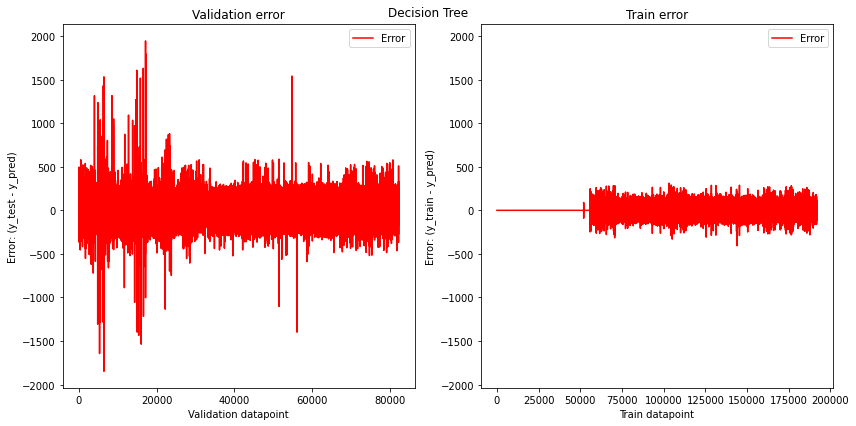

In [7]:
# Split the data into training and test sets
X_train = train.drop('demand_kW', axis=1)
y_train = np.array(train['demand_kW']).ravel()

X_val = val.drop('demand_kW', axis=1)
y_val = np.array(val['demand_kW']).ravel()

X_test = test.drop('demand_kW', axis=1)

# Decision Tree
from sklearn import tree
pipeline = tree.DecisionTreeRegressor(random_state=57)
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
print('Mean crossval score (cv=10)', np.mean(cross_val_score(pipeline, X_train, y_train, cv=10)))

y_pred_val = np.array(list(pipeline.predict(X_val)))
y_pred_train = np.array(list(pipeline.predict(X_train)))

data = {'y_pred': y_pred_val,
        'y_test': y_val}
df = pd.DataFrame(data)
df.to_csv('output/validation_predictions_decisiontree.csv', index=False)
print(mean_squared_error(y_val, y_pred_val))

# Show Error on Training Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 2)
plt.title("Train error")
plt.plot(np.arange(len(y_pred_train)), y_train - y_pred_train, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")

# Show Error on Validation Set
ax2 = plt.subplot(1, 2, 1, sharey = ax1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred_val)), y_val - y_pred_val, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

fig.tight_layout()
plt.suptitle("Decision Tree")
plt.show()

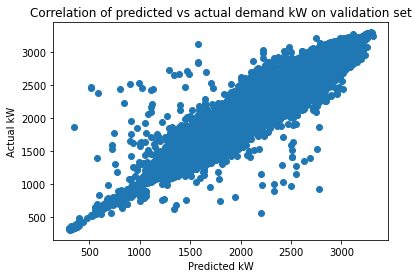

In [8]:
plt.plot(y_pred_val, y_val, 'o')
plt.xlabel('Predicted kW')
plt.ylabel('Actual kW')
plt.title('Correlation of predicted vs actual demand kW on validation set')
plt.show()

# correlation = np.corrcoef(y_val, y_pred_val)[0,1]
# print(correlation)

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Split the data into training and test sets
X_train = train.drop('demand_kW', axis=1)
y_train = np.array(train['demand_kW']).ravel()

X_val = val.drop('demand_kW', axis=1)
y_val = np.array(val['demand_kW']).ravel()

X_test = test.drop('demand_kW', axis=1)

clf = HistGradientBoostingRegressor(max_iter=5000, loss='squared_error', l2_regularization=0.3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

data = {'y_pred': y_pred,
        'y_val': y_val}
pd.DataFrame(data).to_csv('y_pred_val.csv', index=False)

mse = mean_squared_error(y_val, y_pred)
print('MSE val', mse)
print('Score', clf.score(X_val, y_val))
print('Trained on:', clf.feature_names_in_)

tr = clf.train_score_
vl = clf.validation_score_
x = np.arange(0, clf.n_iter_ + 1)
plt.plot(x, tr, label='train score')
plt.plot(x, vl, label='validation score')
plt.title(f'Train and val score \n mse: {mse}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.show()

KeyboardInterrupt: 

# Random Forest

Mean crossval score (cv=10) -1.4961776171127397
9130.931943478297


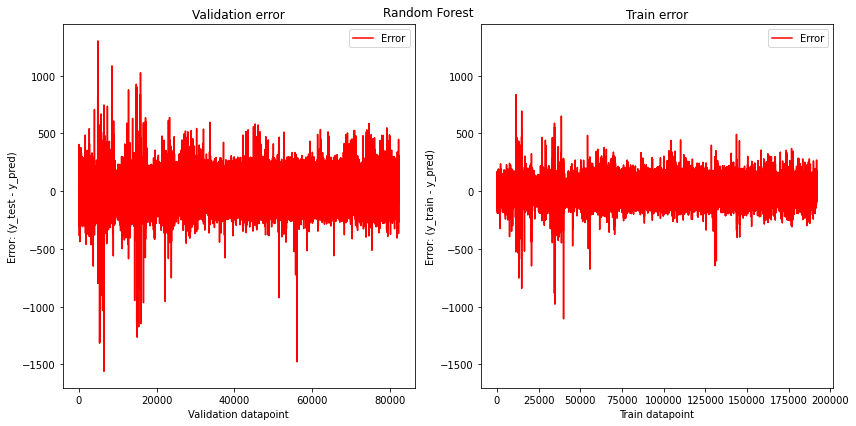

In [11]:
# Split the data into training and test sets
X_train = train.drop('demand_kW', axis=1)
y_train = np.array(train['demand_kW']).ravel()

X_val = val.drop('demand_kW', axis=1)
y_val = np.array(val['demand_kW']).ravel()

X_test = test.drop('demand_kW', axis=1)

# Decision Tree
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
# create regressor object
pipeline = RandomForestRegressor(n_estimators=10, random_state=0)
 
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
print('Mean crossval score (cv=10)', np.mean(cross_val_score(pipeline, X_train, y_train, cv=10)))

y_pred_val = np.array(list(pipeline.predict(X_val)))
y_pred_train = np.array(list(pipeline.predict(X_train)))

data = {'y_pred': y_pred_val,
        'y_test': y_val}
df = pd.DataFrame(data)
df.to_csv('output/validation_predictions_randomforest.csv', index=False)
print(mean_squared_error(y_val, y_pred_val))

# Show Error on Training Set
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 2)
plt.title("Train error")
plt.plot(np.arange(len(y_pred_train)), y_train - y_pred_train, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Train datapoint")
plt.ylabel("Error: (y_train - y_pred)")

# Show Error on Validation Set
ax2 = plt.subplot(1, 2, 1, sharey = ax1)
plt.title("Validation error")
plt.plot(np.arange(len(y_pred_val)), y_val - y_pred_val, "r-", label="Error")
plt.legend(loc="upper right")
plt.xlabel("Validation datapoint")
plt.ylabel("Error: (y_test - y_pred)")

fig.tight_layout()
plt.suptitle("Random Forest")
plt.show()

Correlation: 0.9712457580899697
R^2: 0.9433183226077599


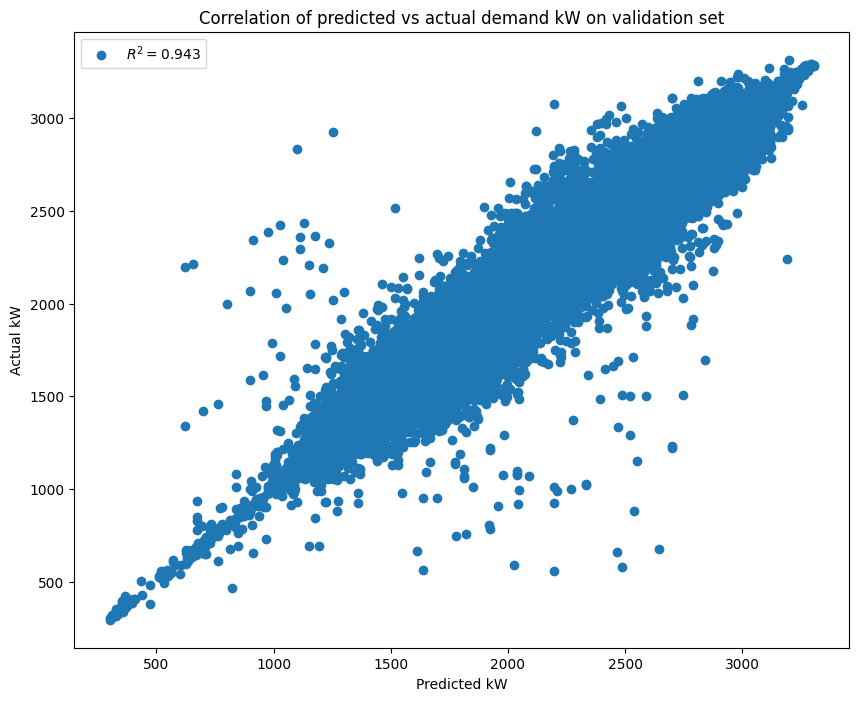

In [78]:
y_pred_val = [float(x) for x in y_pred_val]
y_val = [float(x) for x in y_val]

correlation = np.corrcoef(y_val, y_pred_val)[0,1]
print('Correlation:', correlation)
print('R^2:', correlation**2)

plt.figure(figsize=(10,8))
plt.plot(y_pred_val, y_val, 'o', label=f'$R^2=${round(correlation**2, 3)}')
plt.xlabel('Predicted kW')
plt.ylabel('Actual kW')
plt.title('Correlation of predicted vs actual demand kW on validation set')
plt.legend()
plt.show()